In [1]:
import locale
from visualize import viztool
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
from scipy import stats
import seaborn as sns

# Set locale to German
locale.setlocale(locale.LC_TIME, "de_DE.utf8")

# Apply the default theme
sns.set_theme()


def save_data():
    df = pd.DataFrame()

    for city in ["duesseldorf", "kiel", "dresden"]:
        city_df = viztool.retrieveSlotData(city=city, concern=None)
        df = pd.concat([df, city_df])

    df.to_csv("data.csv")


# save_data()

df = viztool.read_data_from_csv()

df["days_open"] = df["total_delta"].dt.total_seconds() / 3600 / 24

df["days_until_slot"] = df["time_until_slot"].dt.total_seconds() / 3600 / 24

In [2]:
concerns = [
    "Personalausweis - Antrag",
    "Reisepass - Antrag",
    "Anmeldung",
    "Ummeldung",
    "Abmeldung",
]

# cities = ["Duesseldorf", "Dresden", "Kiel"]
cities = ["Duesseldorf", "Dresden"]

concern = "Personalausweis - Antrag"
offices = ["Bilk","Benrath"]

filtered_df = df[
    (df["concern"] == concern)
    & (df["city"].isin(cities))
    # & (df["office"].isin(offices))
]
# filtered_df.dropna(subset=["taken"], inplace=True)

# remove where delta smaller than 5 min
# filtered_df = filtered_df[filtered_df["total_delta"] > pd.Timedelta(minutes=5)]
# filtered_df.sort_values("total_delta", inplace=True)

/tmp/ipykernel_1658/4197798349.py:44: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax[i].legend(
/tmp/ipykernel_1658/4197798349.py:44: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax[i].legend(


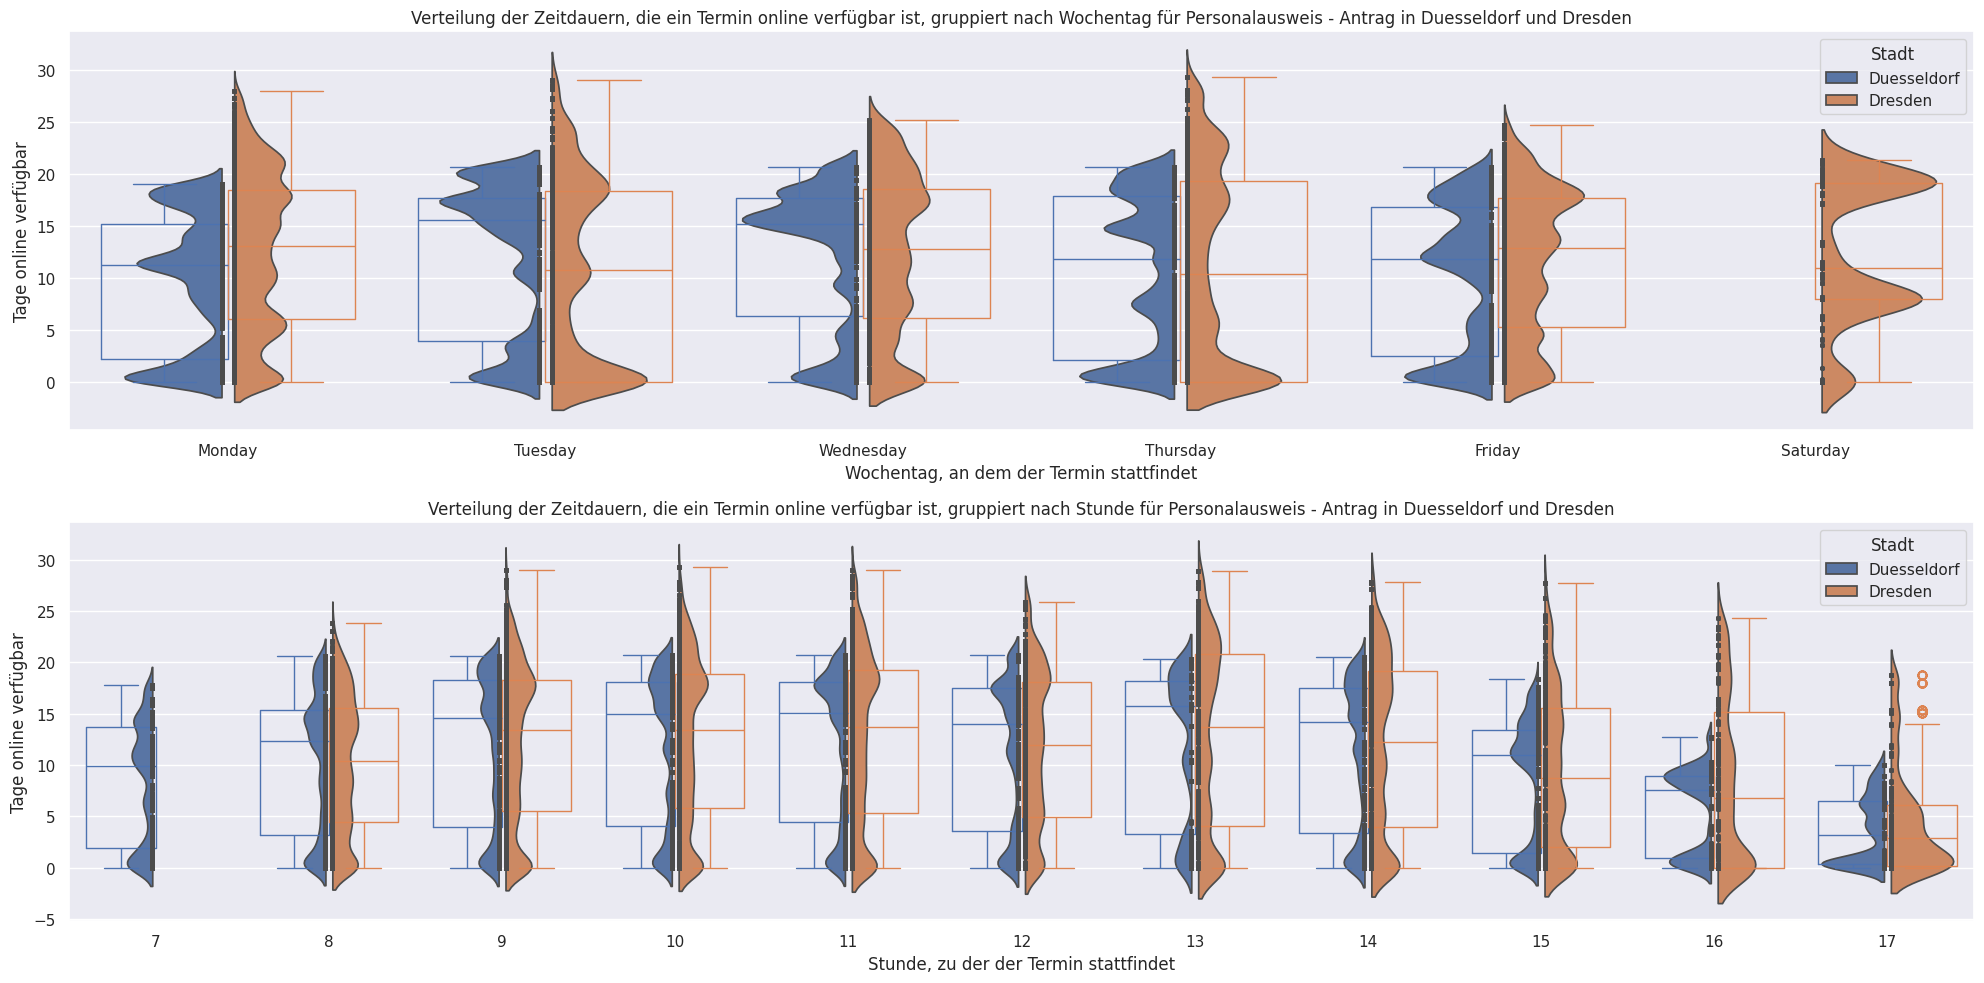

In [3]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)

for i, groupby in enumerate(["weekday", "hour"]):
    label = {
            "weekday": "Wochentag",
            "hour": "Stunde",
        }
    sns.violinplot(
        x=groupby,
        y="days_open",
        data=filtered_df,
        ax=ax[i],
        inner="point",
        hue="city",
        split=True,
        gap=0.1,
        order=(
            [
                "Monday",
                "Tuesday",
                "Wednesday",
                "Thursday",
                "Friday",
                "Saturday",
            ]
            if groupby == "weekday"
            else None
        ),
    )
    sns.boxplot(
        x=groupby,
        y="days_open",
        data=filtered_df,
        ax=ax[i],
        showfliers=True,
        linewidth=1,
        fill=False,
        hue="city",
    )
    title = f"Verteilung der Zeitdauern, die ein Termin online verfügbar ist, gruppiert nach {label[groupby]} für {concern} in {' und '.join(cities)}"
    ax[i].set_title(title)
    ax[i].set_xlabel(f"{'Wochentag, an dem der Termin stattfindet' if groupby == 'weekday' else 'Stunde, zu der der Termin stattfindet'}")
    ax[i].set_ylabel("Tage online verfügbar")
    ax[i].legend(
        title="Stadt", handles=ax[i].get_legend_handles_labels()[0], labels=cities
    )
plt.tight_layout()

plt.savefig("./bachelorarbeit/bilder/violinplot_days_open.png", bbox_inches="tight")
plt.show()

/tmp/ipykernel_1658/2061388673.py:46: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax[i].legend(
/tmp/ipykernel_1658/2061388673.py:46: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax[i].legend(


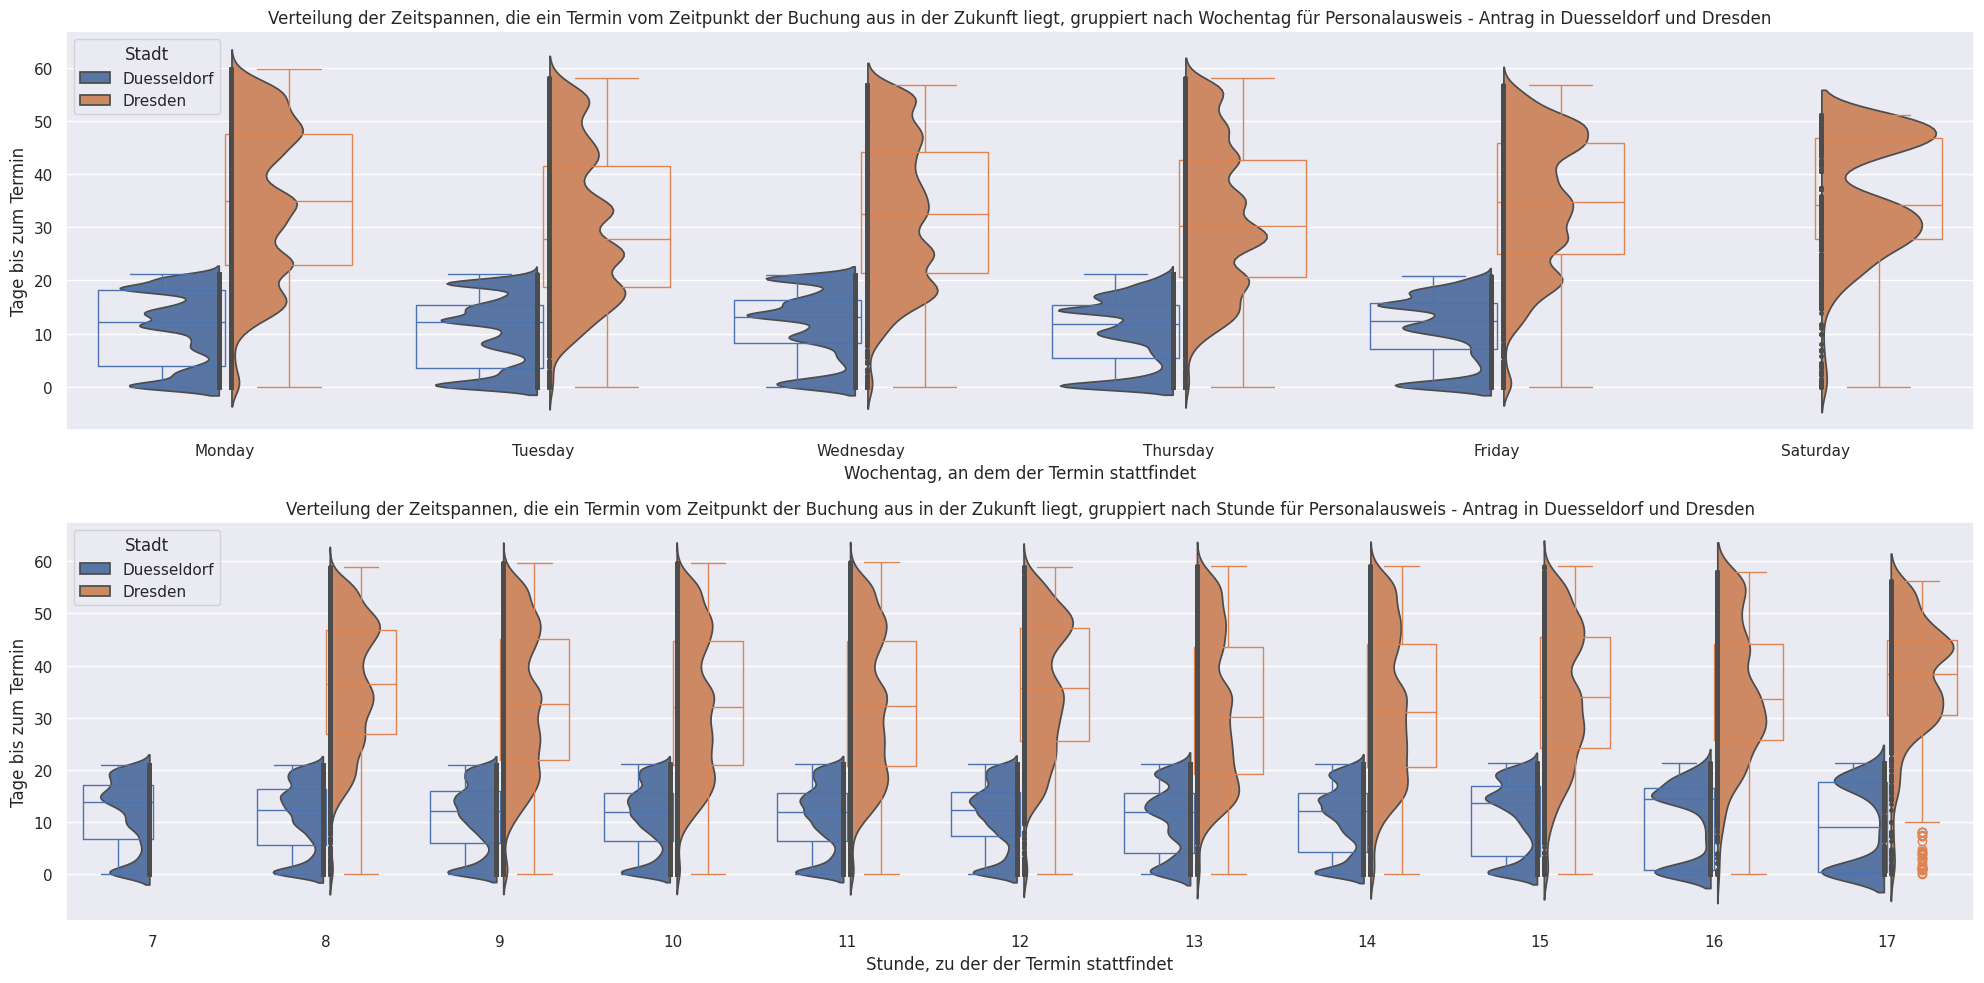

In [4]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)

for i, groupby in enumerate(["weekday", "hour"]):

    label = {
        "weekday": "Wochentag",
        "hour": "Stunde",
    }
    sns.violinplot(
        x=groupby,
        y="days_until_slot",
        data=filtered_df,
        ax=ax[i],
        inner="point",
        hue="city",
        split=True,
        gap=0.1,
        order=(
            [
                "Monday",
                "Tuesday",
                "Wednesday",
                "Thursday",
                "Friday",
                "Saturday",
            ]
            if groupby == "weekday"
            else None
        ),
    )

    sns.boxplot(
        x=groupby,
        y="days_until_slot",
        data=filtered_df,
        ax=ax[i],
        showfliers=True,
        linewidth=1,
        fill=False,
        hue="city",
    )
    title = f"Verteilung der Zeitspannen, die ein Termin vom Zeitpunkt der Buchung aus in der Zukunft liegt, gruppiert nach {label[groupby]} für {concern} in {' und '.join(cities)}"
    ax[i].set_title(title)
    ax[i].set_xlabel(f"{'Wochentag, an dem der Termin stattfindet' if groupby == 'weekday' else 'Stunde, zu der der Termin stattfindet'}")
    ax[i].set_ylabel("Tage bis zum Termin")
    ax[i].legend(
        title="Stadt", handles=ax[i].get_legend_handles_labels()[0], labels=cities
    )
plt.tight_layout()

plt.savefig(
    "./bachelorarbeit/bilder/violinplot_days_until_slot.png", bbox_inches="tight"
)
plt.show()

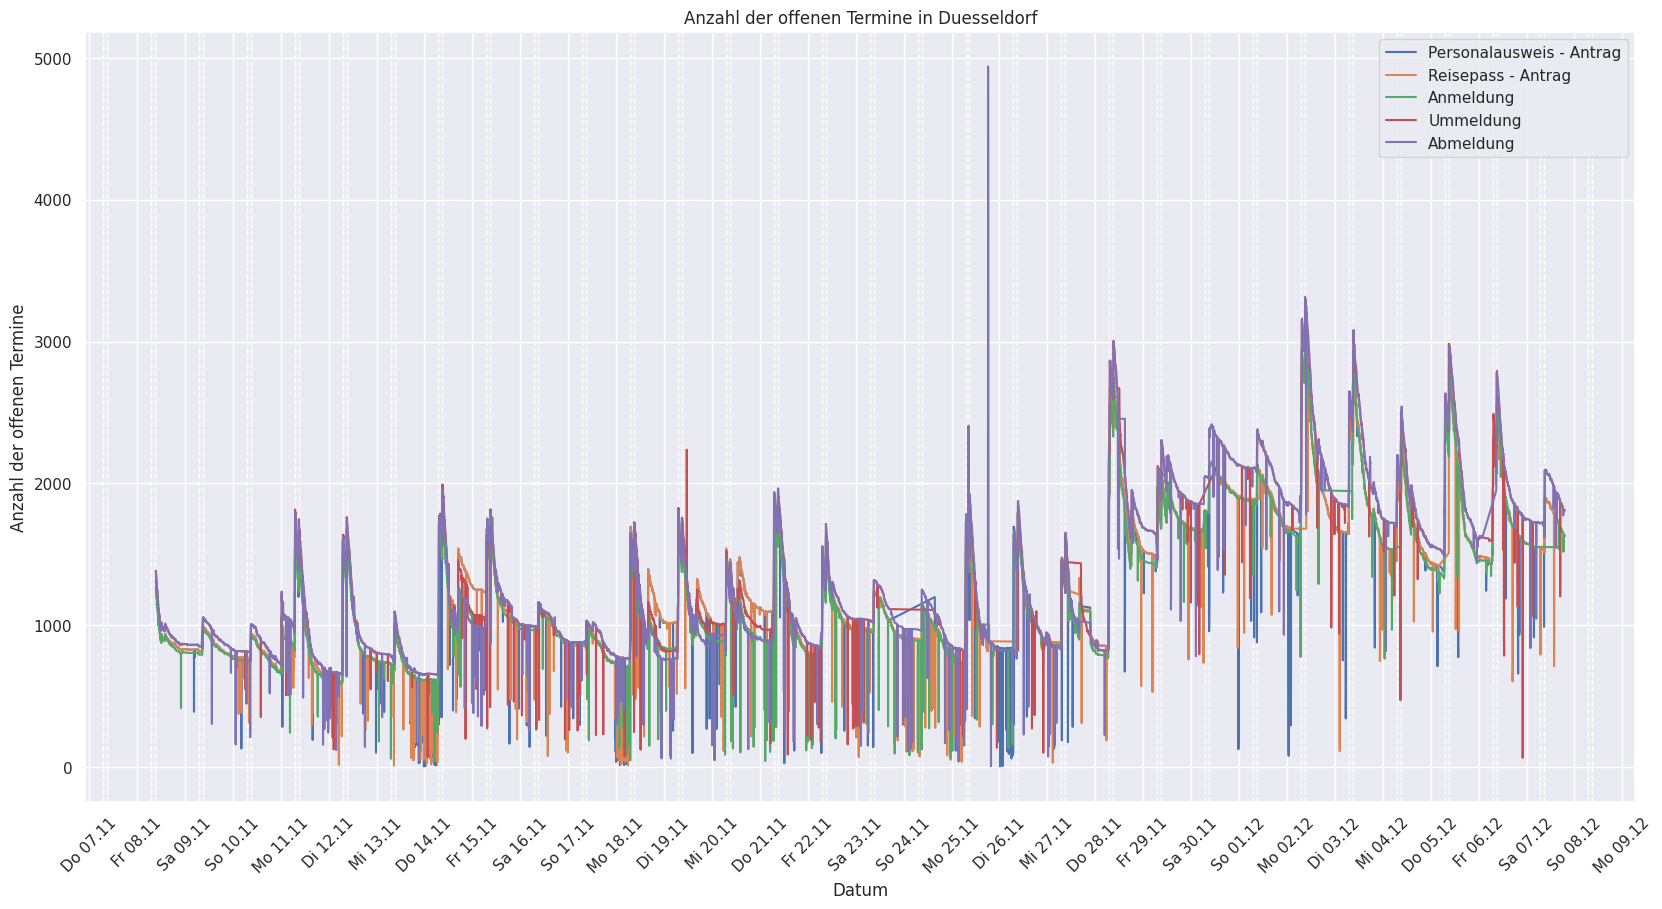

In [5]:
# duesseldorf all concerns
fig, ax = plt.subplots(figsize=(20, 10))



for concern in concerns:
    count = viztool.create_time_series(
        df, city="Duesseldorf", concern=concern
    )
    sns.lineplot(data=count, x="timestamp", y="count", ax=ax, label=concern)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 9]))
ax.xaxis.grid(True, which="minor", linestyle="--")

ax.set_title("Anzahl der offenen Termine in Duesseldorf")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl der offenen Termine")

plt.savefig(
    f"bachelorarbeit/bilder/offene_termine_duesseldorf_alle_anliegen.png",
)

plt.show()

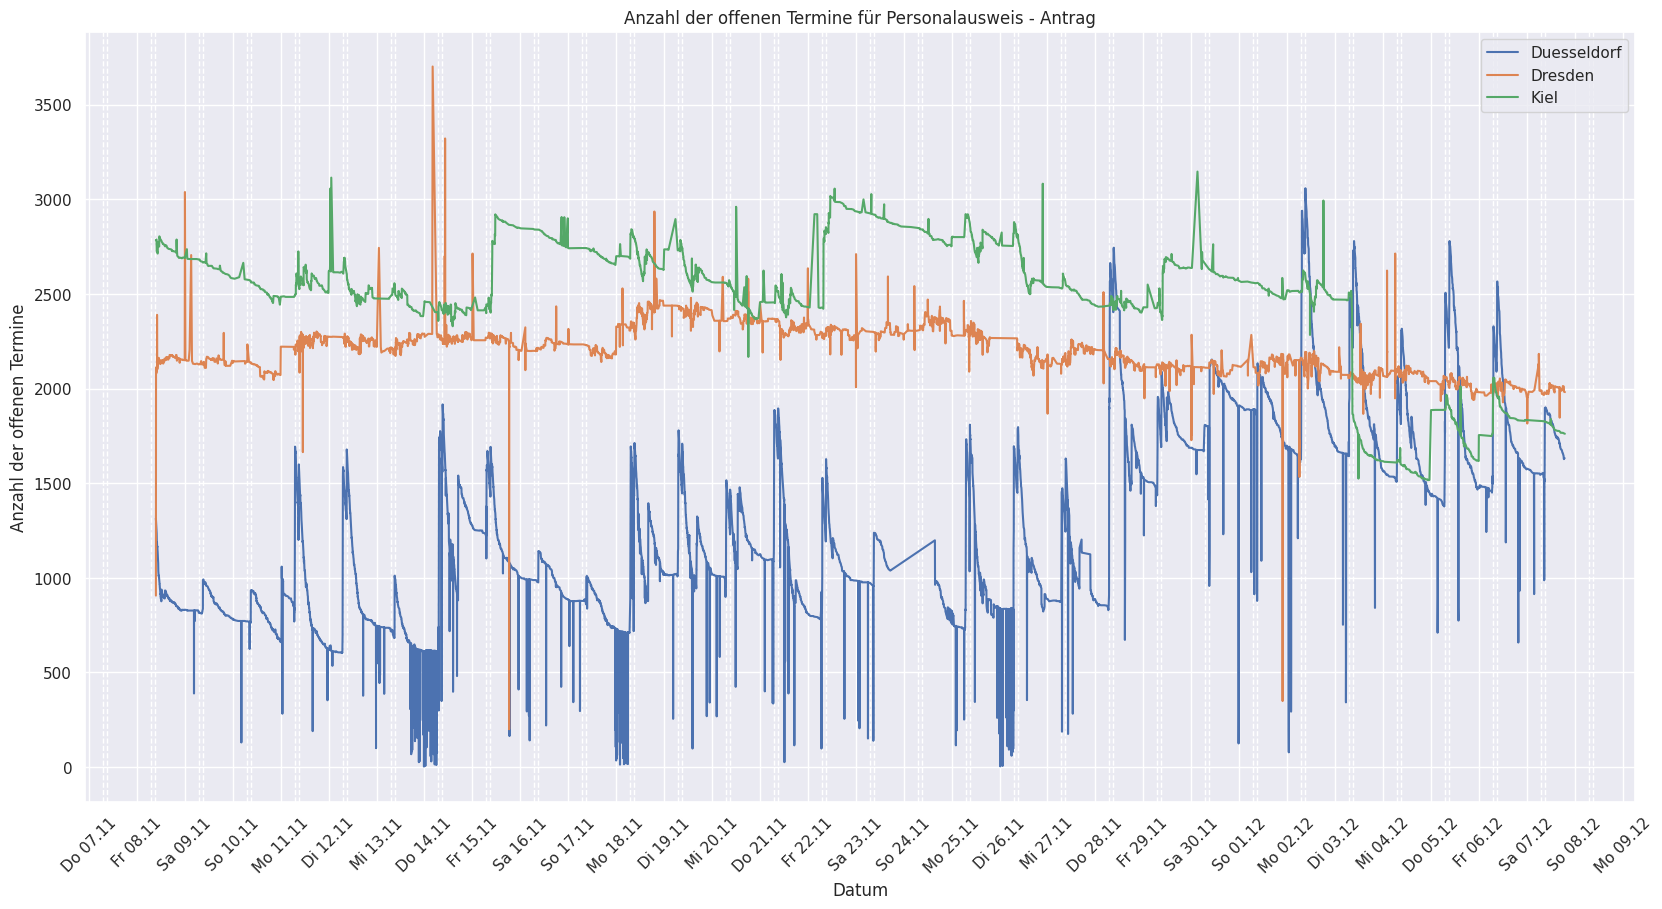

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))

for c in ['Duesseldorf', 'Dresden', 'Kiel']:
    count = viztool.create_time_series(
        df, city=c, concern="Personalausweis - Antrag"
    )
    sns.lineplot(data=count, x="timestamp", y="count", ax=ax, label=c)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 9]))
ax.xaxis.grid(True, which="minor", linestyle="--")

ax.set_title("Anzahl der offenen Termine für Personalausweis - Antrag")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl der offenen Termine")

plt.savefig(f"bachelorarbeit/bilder/offene_termine_personalausweis_alle_staedte.png", bbox_inches="tight")
plt.show()

In [7]:
dues_all = df[(df["concern"] == "Personalausweis - Antrag") & (df["city"] == "Duesseldorf")]


dues_ohne_dz = viztool.create_time_series(
    dues_all,
    city="Duesseldorf",
    concern="Personalausweis - Antrag",
    exclude_office="Dienstleistungszentrum",
)

dues_nur_dz = viztool.create_time_series(
    dues_all,
    city="Duesseldorf",
    concern="Personalausweis - Antrag",
    office="Dienstleistungszentrum",
)

# dues_nur_dz[dues_nur_dz["delta"] < pd.Timedelta(5, unit="m")]

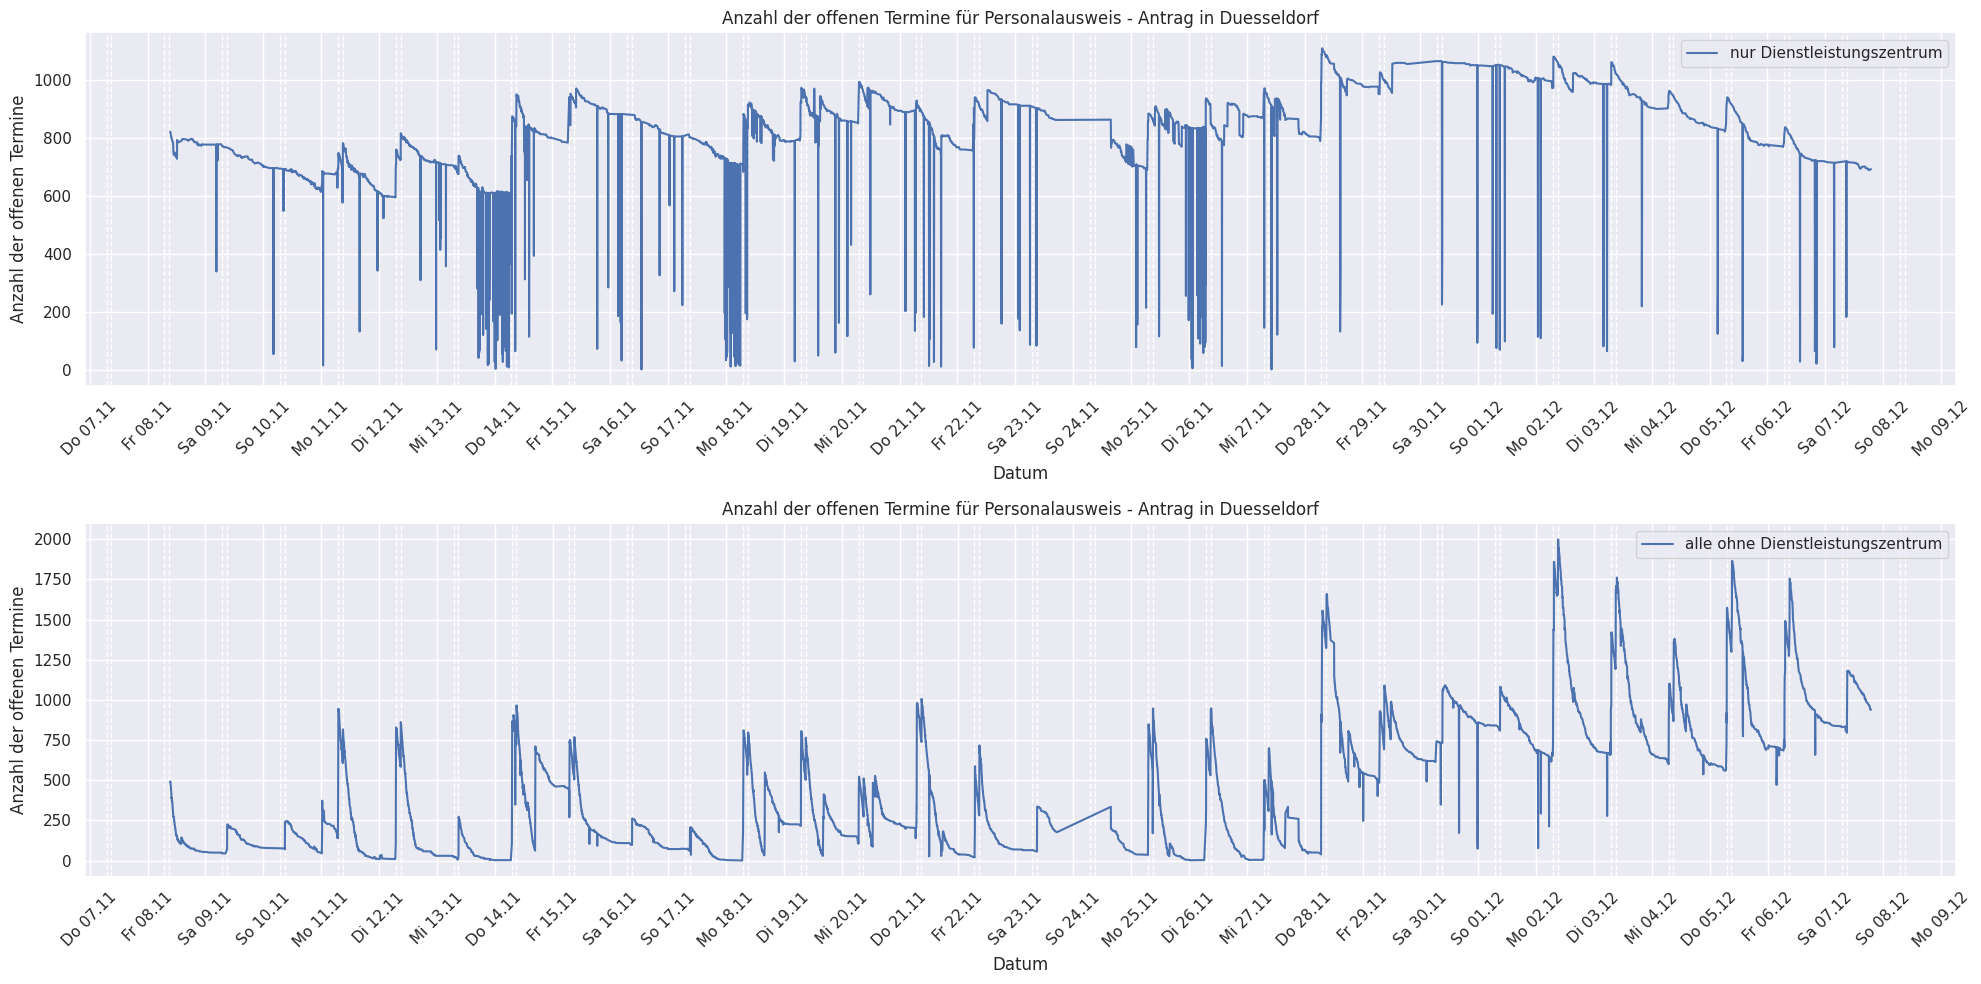

In [8]:
# duesseldorf ohne Dienstleistungszenrum
fig, axs = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)

for i, data in enumerate([dues_nur_dz, dues_ohne_dz]):
    sns.lineplot(
        data=data,
        x="timestamp",
        y="count",
        ax=axs[i],
        label=f"{'nur Dienstleistungszentrum' if i == 0 else 'alle ohne Dienstleistungszentrum'}",
    )

    axs[i].xaxis.set_major_locator(mdates.DayLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m"))
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)

    axs[i].xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 9]))
    axs[i].xaxis.grid(True, which="minor", linestyle="--")

    axs[i].set_title(
        "Anzahl der offenen Termine für Personalausweis - Antrag in Duesseldorf"
    )
    axs[i].set_xlabel("Datum")
    axs[i].set_ylabel("Anzahl der offenen Termine")

plt.tight_layout()
plt.savefig(
    f"bachelorarbeit/bilder/offene_termine_personalausweis_duesseldorf_mit_ohne_dz.png",
)
plt.show()